<a href="https://colab.research.google.com/github/sydney-machine-learning/sentimentanalysis-USelections/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install langdetect
!pip install geopandas

     |████████████████████████████████| 983kB 4.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=8a0a1af82406b4499d8646582ce1bec7ae47d5ea5984a56456235ff1f44a5553
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 972kB 5.0MB/s 
     |████████████████████████████████| 6.5MB 10.6MB/s 
     |████████████████████████████████| 14.8MB 3.2MB/s 


In [4]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# **Initial EDA**

## 1. Trump

In [17]:
df1=pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv', lineterminator='\n')
df1.head(2).T

,0,1
created_at,2020-10-15 00:00:01,2020-10-15 00:00:01
tweet_id,1.31653e+18,1.31653e+18
tweet,#Elecciones2020 | En #Florida: #JoeBiden dice ...,"Usa 2020, Trump contro Facebook e Twitter: cop..."
likes,0,26
retweet_count,0,9
source,TweetDeck,Social Mediaset
user_id,3.60667e+08,3.31618e+08
user_name,El Sol Latino News,Tgcom24
user_screen_name,elsollatinonews,MediasetTgcom24
user_description,🌐 Noticias de interés para latinos de la costa...,Profilo ufficiale di Tgcom24: tutte le notizie...


stat details

In [18]:
df1.describe()

,tweet_id,likes,retweet_count,user_id,user_followers_count,lat,long
count,9.709190e+05,970919.000000,970919.000000,9.709190e+05,9.709190e+05,445719.000000,445719.000000
mean,1.322494e+18,7.477011,1.698500,4.468311e+17,2.260357e+04,35.697936,-40.369638
std,2.555133e+15,158.058117,40.028419,5.544702e+17,3.042152e+05,18.823129,67.531751
min,1.316529e+18,0.000000,0.000000,5.310000e+02,0.000000e+00,-90.000000,-175.202642
25%,1.320478e+18,0.000000,0.000000,2.169326e+08,7.700000e+01,32.701939,-96.796856
50%,1.323612e+18,0.000000,0.000000,2.373392e+09,4.410000e+02,39.783730,-74.006015
75%,1.324505e+18,1.000000,0.000000,1.078344e+18,2.066000e+03,46.603354,6.776314
max,1.325589e+18,74084.000000,20491.000000,1.325581e+18,1.911533e+07,90.000000,179.048837


In [ ]:
g=sns.pairplot(df1, vars=['tweet_id','likes','retweet_count','user_id','user_followers_count','lat','long'], 
               plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'black'}, height=1.5, dropna=True)
g.map_upper(sns.scatterplot, color='red')
g.map_lower(sns.scatterplot, color='red')
g.map_diag(plt.hist, color='red')

KeyboardInterrupt: ignored

In [ ]:
df1.isnull().sum()

## Biden

In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_joebiden.csv', lineterminator='\n')
df2.head(2).T

In [ ]:
df2.describe()

In [ ]:
sns.pairplot(df2, vars=['tweet_id','likes','retweet_count','user_id','user_followers_count','lat','long'], 
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}, height=1.5, dropna=True)

In [ ]:
df2.isnull().sum()

# Further EDA

In [5]:
# Reading both the csv files
tweets_biden = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Clean data
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

In [6]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

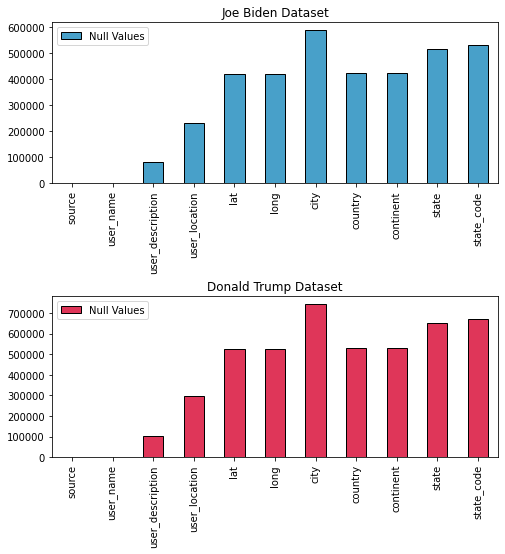

In [7]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

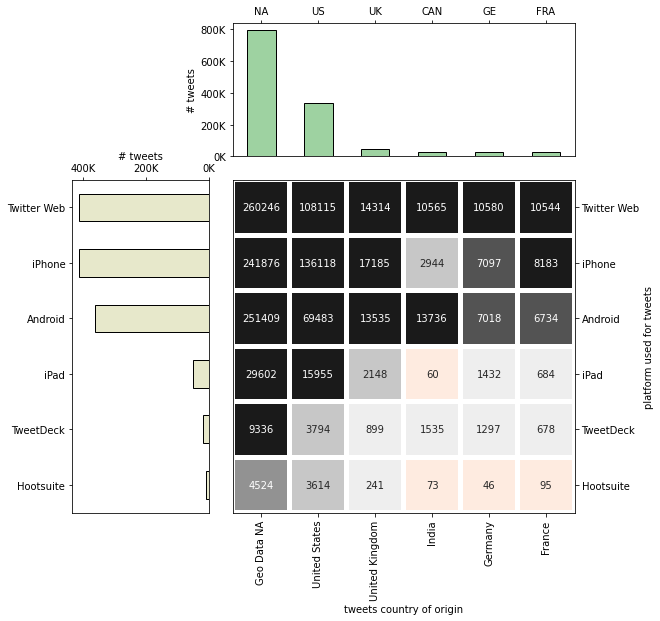

In [8]:
source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0) 

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0) 
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0) 
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

In [9]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden[['lat','long']].copy(),tweets_trump[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 30.8 s, sys: 248 ms, total: 31.1 s
Wall time: 31.1 s


In [11]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

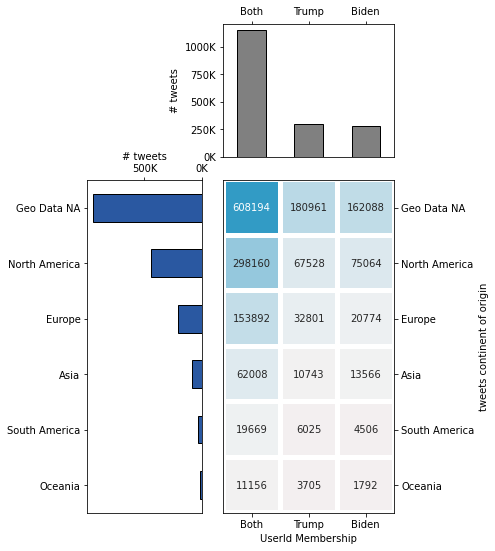

In [12]:
fig, ax=plt.subplots(2,2, figsize=(5.5,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[4],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

In [13]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


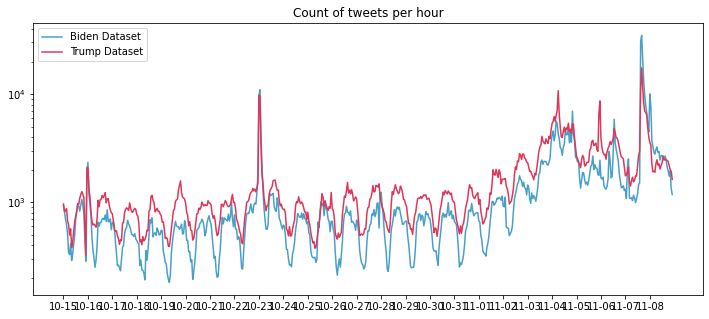

In [14]:
plt.figure(figsize=(12,5))
p6=sns.lineplot(cnt_tbiden.index, cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.index, cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

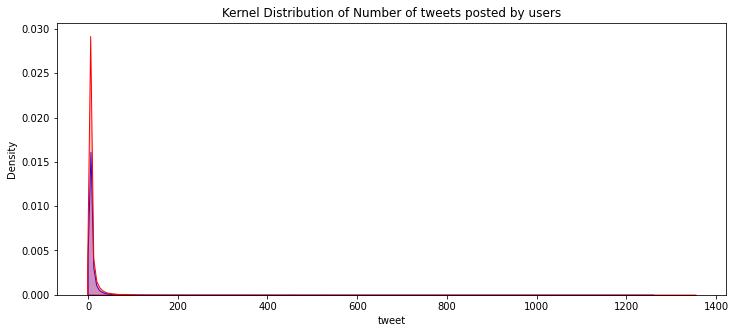

In [15]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Number of tweets posted by users')
sns.kdeplot(tweets_biden.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


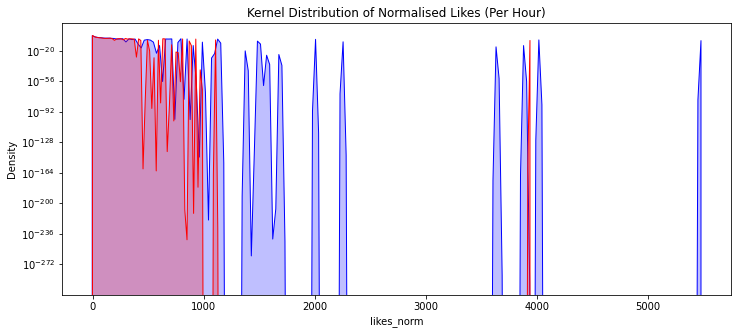

In [16]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Likes (Per Hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


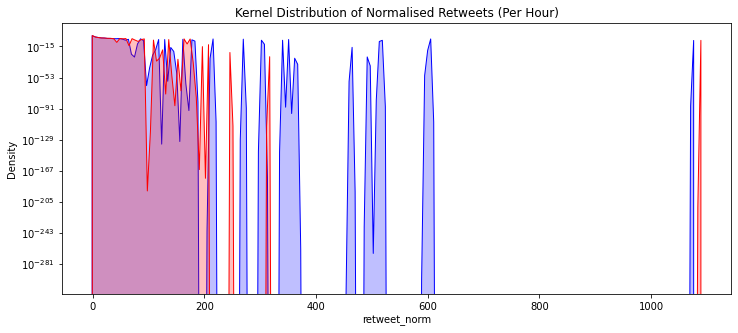

In [17]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Retweets (Per Hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

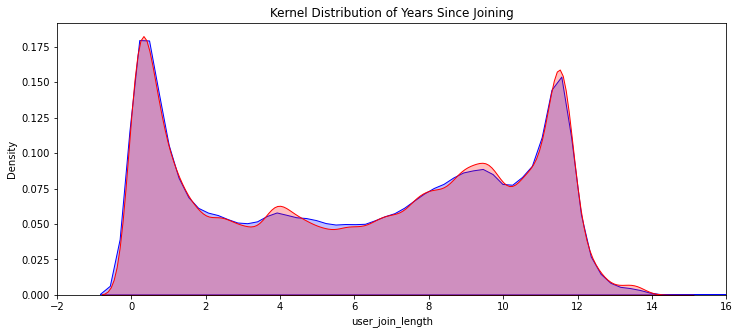

In [18]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(-2, 16)
line_ax.set_title('Kernel Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

# P2

In [19]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

## DATA CLEANING

In [23]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [24]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])


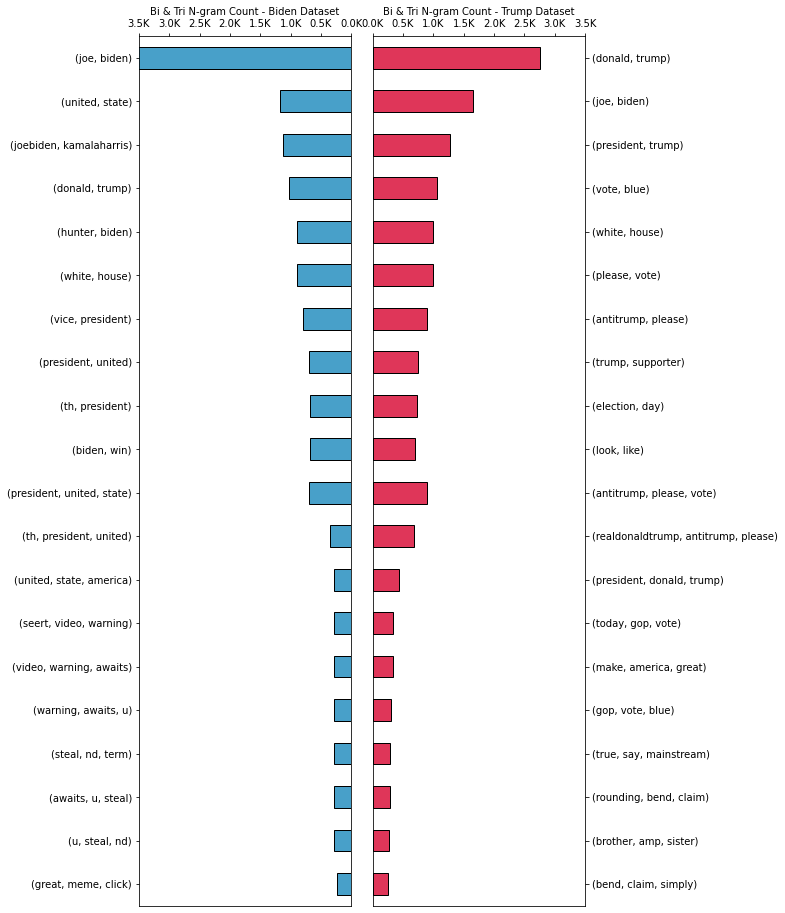

In [25]:
fig, ax=plt.subplots(1,2, figsize=(8,16), 
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

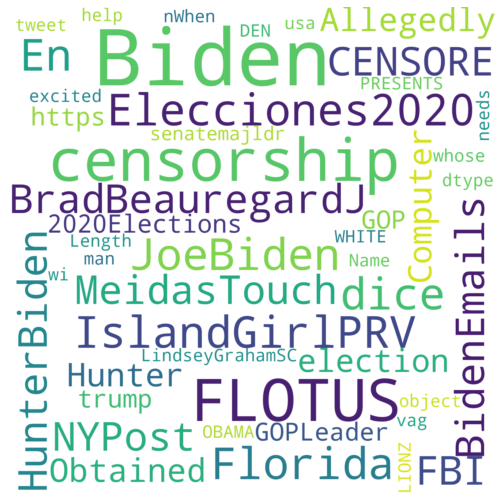

In [26]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

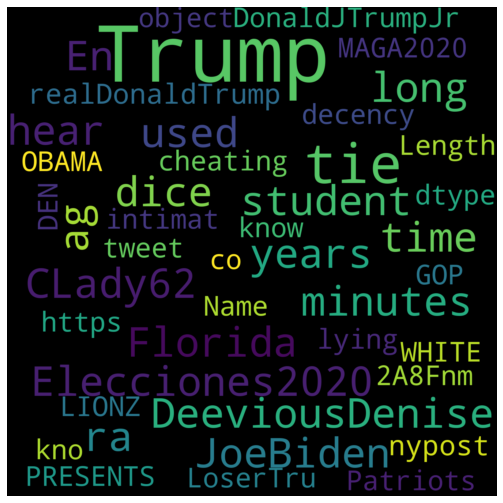

In [27]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()